# Insider Trading Analysis - SEC Edgar

## Boilerplate

Let's start by defining some boilerplate to define global variables.

# Download Form 4 Data

Let's implement the download and XML parse methods. The XML parser extracts all non-derivative transactions listed in the 4 filing. It considers `disposal` and `acquisition` of items and calculates the sum of all transactions (sold and bought).

**Important:** the downloader doesn't differentiate between filing issuer and reporter. In other words, we download the issuer's and reporter's filing. The reported transactions in both filings are the same and we double count transactions. That's OK for demonstration purposes but has to be cleaned when building a production version.

In [196]:
files = []
data = []
prices = []
form = "4"
ticker="SCHW"
year= "2015"
month= "01"
day= "01"

In [197]:
from sec_edgar_downloader import Downloader
dl = Downloader()

#TODO: calculate dates missing based on files saved locally

dl.get(form, ticker, after=year+'-'+month+'-'+day)

902

## Compressing Filenames

Adding filename to filings open XML data

In [198]:
import os
def compress_filings (filings):
    compressed_filings = []
    for filingDir in filings:
        fullSubmissionFname = os.path.join(path_form, filingDir, "filing-details.xml")
        compressed_filings.append(fullSubmissionFname)
    return compressed_filings

In [199]:
import os, re
pattern = re.compile("([0-9]+)")
path_form = os.path.join("sec-edgar-filings", ticker, '4')

files = compress_filings(os.listdir(path_form))
# files[0:1]

# Open XML Files

In [200]:
import xml.etree.ElementTree as ET
import re

def open_xml(file):
    xml_file=  open(file)
    data = xml_file.read()
    xml_file.close()
    matcher = re.compile('<\?xml.*ownershipDocument>', flags=re.MULTILINE|re.DOTALL)
    matches = matcher.search(data)
    # the first matching group is the extracted XML of interest
    xml = matches.group(0)
    # instantiate the XML object
    root = ET.fromstring(xml)
    return root

In [201]:
# Calculate the total transaction amount in $ of a giving form 4 in XML
def flatten_info(xml):

    if xml is None:
        return
    try:
        periodOfReport = xml.findall("./periodOfReport")[0].text
        rptOwnerName = xml.findall("./reportingOwner/reportingOwnerId/rptOwnerName")[0].text
        issuerTradingSymbol = xml.findall("./issuer/issuerTradingSymbol")[0].text
        
        isOfficer = xml.find("./reportingOwner/reportingOwnerRelationship/isOfficer")

        nonDerivativeTransactions = xml.findall("./nonDerivativeTable/nonDerivativeTransaction")
        for t in nonDerivativeTransactions:
            # P is purchase and S is sell
            generalCode = t.find('./transactionCoding/transactionCode').text
            # D for disposed or A for acquired
            action = t.find('./transactionAmounts/transactionAcquiredDisposedCode/value').text
            # number of shares disposed/acquired
            shares = t.find('./transactionAmounts/transactionShares/value').text
            # price
            priceRaw = t.find('./transactionAmounts/transactionPricePerShare/value')
            price = 0 if priceRaw is None else priceRaw.text
            # set prefix to -1 if derivatives were disposed. set prefix to 1 if derivatives were acquired.
            prefix = -1 if action == 'D' else 1
            # calculate transaction amount in $
            amount = prefix * float(shares) * float(price)
            data.append({
                'periodOfReport': periodOfReport,
                'generalCode': generalCode,
                'issuerTradingSymbol': issuerTradingSymbol,
                'rptOwnerName': rptOwnerName,
                'action': action, 
                'shares': shares,
                'amount': amount,
                'price': price,
                'isOfficer': 0 if isOfficer is None else isOfficer.text

            })
         
    except Exception as exception:
        print(exception, xml)
    

In [202]:
# FOR TESTING
# data = []
# xml = open_xml(files[0])
# flatten_info(xml)
# data[:1]

In [203]:
# Get the XML file for each filing
# Calculate the total transaction amount per filing
# Save the calculate transaction values to the data dict
for filing in files:
    xml = open_xml(filing)
    flatten_info(xml)
# Running the function prints the URL of each filing fetched
data[:1]

[{'periodOfReport': '2021-03-01',
  'generalCode': 'M',
  'issuerTradingSymbol': 'SCHW',
  'rptOwnerName': 'Bettinger Walter W',
  'action': 'A',
  'shares': '57815.0000',
  'amount': 3685706.25,
  'price': '63.7500',
  'isOfficer': '1'}]

In [214]:
data.to_json(r'schw.json', orient=’records’)

# Data Plot
Displays insider trading in graph.

In [204]:
import pandas as pd
data = pd.json_normalize(data)

In [205]:
data.periodOfReport.min(), data.periodOfReport.max()

('2015-01-02', '2022-05-26')

In [206]:
data.rptOwnerName.value_counts().head()

SCHWAB CHARLES R      226
Bettinger Walter W     92
Schwab Charles R.      92
Chandoha Marie A       91
Clark Bernard J.       79
Name: rptOwnerName, dtype: int64

In [207]:
data.generalCode.value_counts()

S    495
M    450
G    134
A    118
F     70
P     23
Name: generalCode, dtype: int64

In [208]:
# data.head()
buys = data[data.generalCode == 'P'] 
sells = data[data.generalCode == 'S']
officers_buy = data.query('generalCode == "P" and isOfficer == "1"')
officers_buy.head()

,periodOfReport,generalCode,issuerTradingSymbol,rptOwnerName,action,shares,amount,price,isOfficer
393,2022-04-27,P,SCHW,Bettinger Walter W,A,4341.0000,2.975673e+05,68.5481,1
577,2018-12-24,P,SCHW,Bettinger Walter W,A,93090.0000,3.639167e+06,39.0930,1
578,2018-12-24,P,SCHW,Bettinger Walter W,A,31579.0000,1.198906e+06,37.9653,1
722,2022-04-26,P,SCHW,Bettinger Walter W,A,26108.0000,1.789688e+06,68.5494,1
793,2022-04-28,P,SCHW,Bettinger Walter W,A,9723.0000,6.626769e+05,68.1556,1


In [209]:
import yfinance as yf

start_date = "{}-{}-{}".format(year, month, day)
prices = yf.download(ticker, start=start_date)
prices.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,30.410000,30.570000,29.809999,30.219999,27.791361,4537600
2015-01-05,29.969999,30.000000,29.129999,29.209999,26.862528,5931400
2015-01-06,29.209999,29.280001,27.920000,28.139999,25.878515,9825000
2015-01-07,28.459999,28.700001,28.219999,28.690001,26.384321,7966100
2015-01-08,29.190001,29.520000,29.070000,29.440001,27.074045,5590200


In [210]:
import numpy as np
import pandas as pd

from bokeh.plotting import figure
from bokeh.io import show, output_notebook, reset_output

# importing the modules
reset_output()
output_notebook()

# instantiating the figure object
graph = figure(x_axis_type = "datetime", title = "Stock Closing Prices", tools='save,pan,box_zoom,reset,wheel_zoom,hover')
graph.xaxis.axis_label = 'Date'
graph.yaxis.axis_label = 'Price (in USD)'

def datetime(x):
    return np.array(x, dtype=np.datetime64)
    
# plotting the line graph 
graph.line(datetime(prices.index), prices['Adj Close'], color='#A6CEE3', legend_label=ticker)

# plotting insider trading
graph.circle(datetime(officers_buy.periodOfReport), buys.price, size = 10, color = 'green')
graph.circle(datetime(sells.periodOfReport), sells.price, size = 10, color = 'red')

# displaying the model
show(graph)

Loading BokehJS ...

metric in time window
- trend Q to year
- how do we evaluate the trend?

# Get Insider Trading Activity

In [211]:
def getBins (filings):
    bins = {}
    for index, row in filings.iterrows():
        filedAt = row['periodOfReport']
        nonDerivativeTransactions = row['amount']
        value = bins[filedAt] + nonDerivativeTransactions if filedAt in bins else nonDerivativeTransactions
        bins[filedAt] = round(value, 2)
    return bins

In [212]:
bins = getBins(data)
# bins

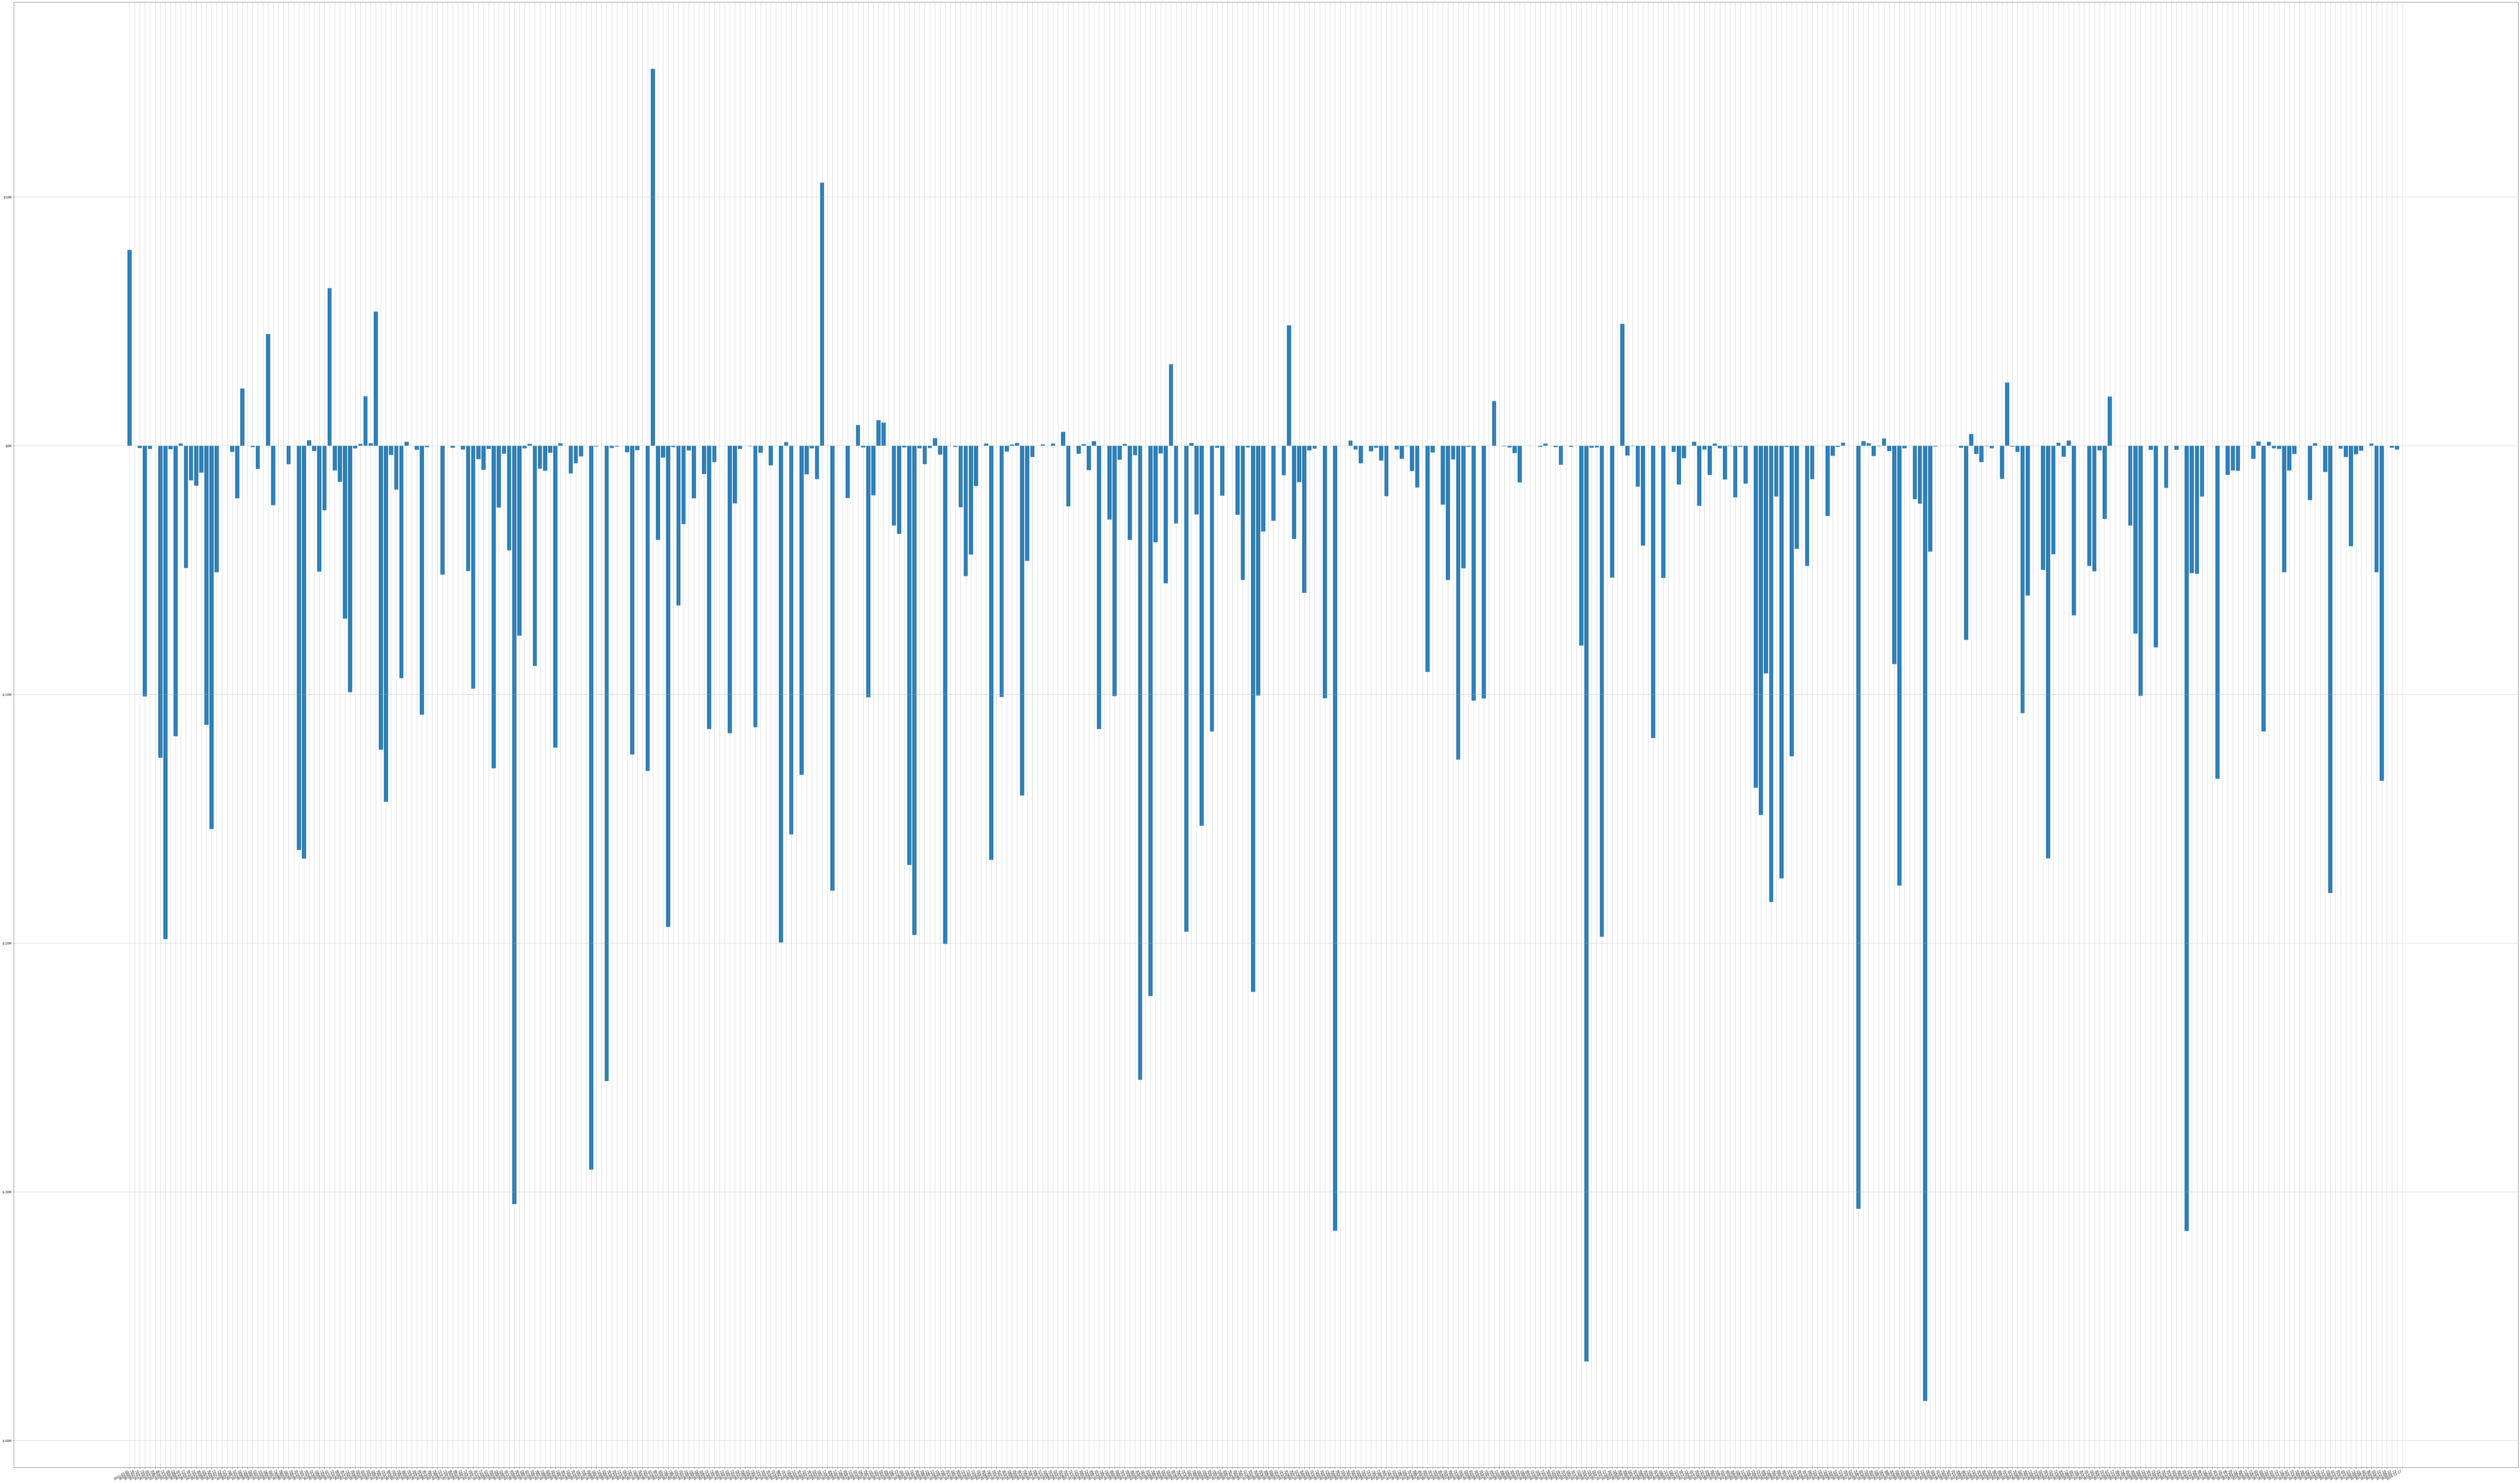

In [213]:
import matplotlib.pyplot as plt
import matplotlib

# Set size of figure
plt.rcParams['figure.figsize'] = [150, 100]

# Prettify y axis: 2000000 to $2M
def millions(x, pos):
    return '${:,.0f}M'.format(x*1e-6)

fig, ax = plt.subplots()
# Define bar plot
ax.bar(range(len(bins)), list(bins.values()), align='center')
ax.grid(True)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions))
# Prettify x axis
fig.autofmt_xdate()
# Set x axis values
plt.xticks(range(len(bins)), list(bins.keys()))
plt.show()